Importing Important libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
url = '/content/drive/MyDrive/p4dataset2020.txt'  # replace with your file path
data = pd.read_csv(url, delim_whitespace=True, header=None)

# Separate the metadata
individual_ids = data.iloc[:, 0]
sex = data.iloc[:, 1]
population = data.iloc[:, 2]

# Extract the nucleobase data
nucleobase_data = data.iloc[:, 3:]

Converting our nucleobase array to a binary array to perform Component Analysis

In [3]:
modes = nucleobase_data.mode().iloc[0]

# Create the binary matrix
binary_matrix = nucleobase_data.apply(lambda x: x != modes, axis=1).astype(int)
binary_matrix.columns=[i for i in range(len(modes))]
binary_matrix.head()


,0,1,2,3,4,5,6,7,8,9,...,10091,10092,10093,10094,10095,10096,10097,10098,10099,10100
0,0,1,0,1,0,1,1,0,0,0,...,0,1,1,1,0,0,1,0,0,1
1,1,0,0,1,0,0,1,0,1,1,...,1,0,1,0,0,0,0,0,0,0
2,1,0,0,1,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
4,0,0,0,0,1,1,1,0,0,0,...,1,0,1,0,0,0,0,0,0,0


<Axes: >

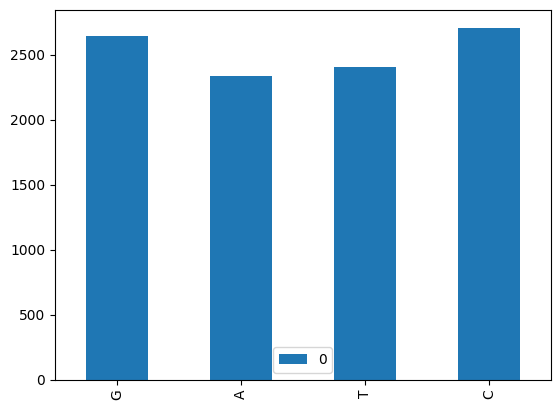

In [4]:
import collections
counts=dict(collections.Counter(modes))
counts=pd.DataFrame(counts,index=[0])
counts.T.plot(kind='bar')

In [39]:
counts

,G,A,T,C
0,2645,2338,2407,2711


PCA

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

scaler = StandardScaler()
binary_matrix_std = scaler.fit_transform(binary_matrix)

pca = PCA()
pca.fit(binary_matrix_std)

pca = PCA(n_components=3)
principal_components = pca.fit_transform(binary_matrix_std)

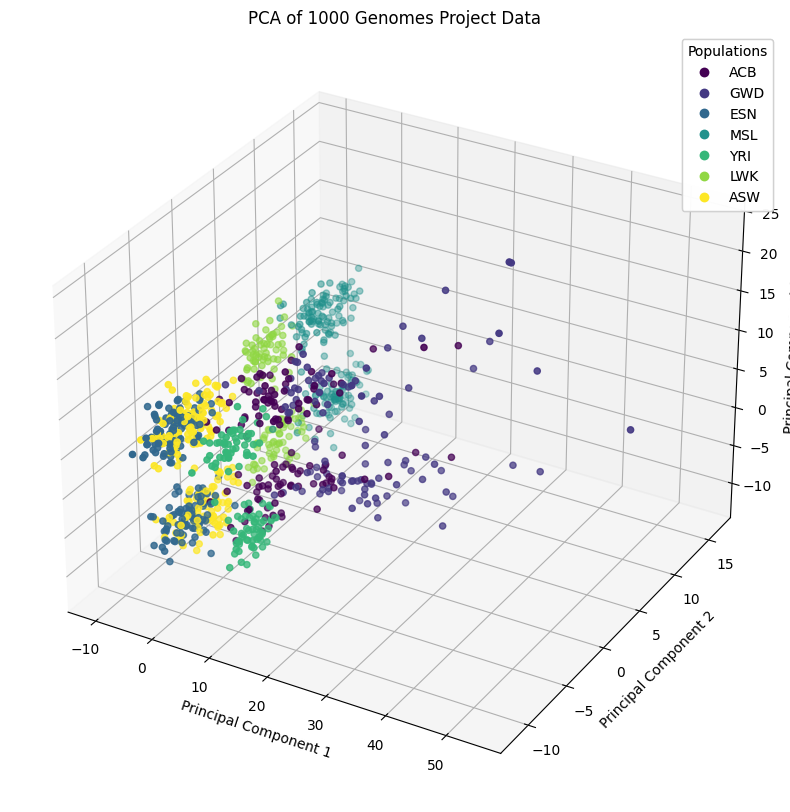

In [6]:
# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
pca_df['Population'] = population
# Map population names to numeric codes
# Create a color map for populations
unique_populations = population.unique()
population_map = {pop: idx for idx, pop in enumerate(unique_populations)}
population_colors = pca_df['Population'].map(population_map)
# Plot the PCA results
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Population'].astype('category').cat.codes, cmap='viridis')
# Adding labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA of 1000 Genomes Project Data')

handles, labels = scatter.legend_elements()
labels = [unique_populations[int(label.split('{')[-1].split('}')[0])] for label in labels]
legend = ax.legend(handles, labels, title="Populations")
ax.add_artist(legend)

plt.show()

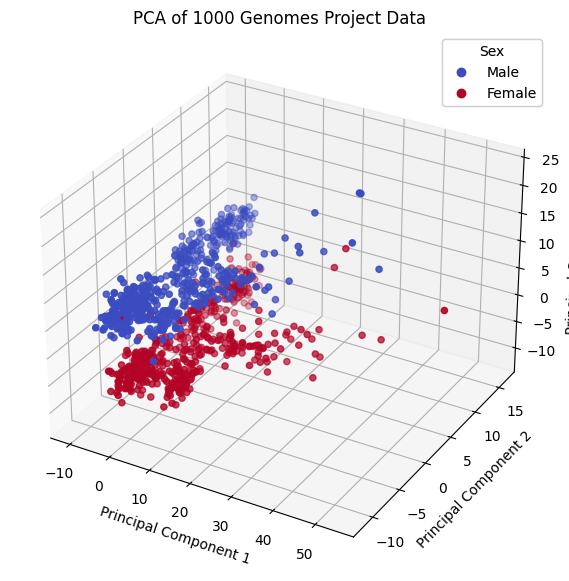

In [7]:
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
pca_df['Sex'] = sex

# Map sex to colors
sex_map = {1: 'Male', 2: 'Female'}
sex_colors = pca_df['Sex'].map(sex_map)
sex_unique=sex.unique()
# Plot the PCA results with sex as hue
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Sex'], cmap='coolwarm', label=sex_colors)

# Adding labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA of 1000 Genomes Project Data')

handles, labels = scatter.legend_elements()
labels = [sex_map[sex_unique[int(label.split('{')[-1].split('}')[0])-1]] for label in labels]
legend = ax.legend(handles, labels, title="Sex")
ax.add_artist(legend)


plt.show()

In [8]:
import itertools
from scipy.spatial.distance import euclidean
pca_df['Population']=population
population_cluster_distances = {}
for i in itertools.combinations(np.unique(pca_df['Population']), 2):
  if i[0]==i[1]:
    continue
  pop_data_1=pca_df[pca_df['Population'] == i[0]][['PC1', 'PC2', 'PC3']]
  pop_data_2=pca_df[pca_df['Population'] == i[1]][['PC1', 'PC2', 'PC3']]
  c1=pop_data_1.mean().values
  c2=pop_data_2.mean().values
  distance = euclidean(c1, c2)
  population_cluster_distances[i] = distance

# Create a DataFrame to visualize the distances
distance_df_1 = pd.DataFrame(list(population_cluster_distances.items()), columns=['Population Pair', 'Cluster Distance'])

# Print the distances
print(distance_df_1.round(2))


   Population Pair  Cluster Distance
0       (ACB, ASW)             10.25
1       (ACB, ESN)             11.59
2       (ACB, GWD)             15.75
3       (ACB, LWK)              5.55
4       (ACB, MSL)             12.06
5       (ACB, YRI)             10.40
6       (ASW, ESN)             21.57
7       (ASW, GWD)             22.04
8       (ASW, LWK)             14.07
9       (ASW, MSL)             20.85
10      (ASW, YRI)             20.56
11      (ESN, GWD)             18.46
12      (ESN, LWK)              8.88
13      (ESN, MSL)             11.78
14      (ESN, YRI)              1.78
15      (GWD, LWK)             18.41
16      (GWD, MSL)              6.79
17      (GWD, YRI)             16.77
18      (LWK, MSL)             13.32
19      (LWK, YRI)              8.10
20      (MSL, YRI)             10.12


In [38]:
from scipy.spatial.distance import euclidean
# Compute cluster distances
population_cluster_distances_within_sex = {}

# Iterate over each population
for pop in pca_df['Population'].unique():
    # Filter data for this population
    pop_data = pca_df[pca_df['Population'] == pop]

    # Separate male and female data
    male_data = pop_data[pop_data['Sex'] == 1][['PC1', 'PC2', 'PC3']]
    female_data = pop_data[pop_data['Sex'] == 2][['PC1', 'PC2', 'PC3']]

    if not male_data.empty and not female_data.empty:
        # Compute centroids
        male_centroid = male_data.mean().values
        female_centroid = female_data.mean().values

        # Compute Euclidean distance between centroids
        distance = euclidean(male_centroid, female_centroid)

        # Store distance for this population
        population_cluster_distances_within_sex[pop] = distance

# Create a DataFrame to visualize the distances
distance_df = pd.DataFrame(list(population_cluster_distances_within_sex.items()), columns=['Population', 'Cluster Distance_between sexes'])

# Print the distances
print(distance_df)


  Population  Cluster Distance_between sexes
0        ACB                       11.420571
1        GWD                       11.107943
2        ESN                       11.115262
3        MSL                       11.385575
4        YRI                       11.366558
5        LWK                       11.171372
6        ASW                       13.131780


<Axes: >

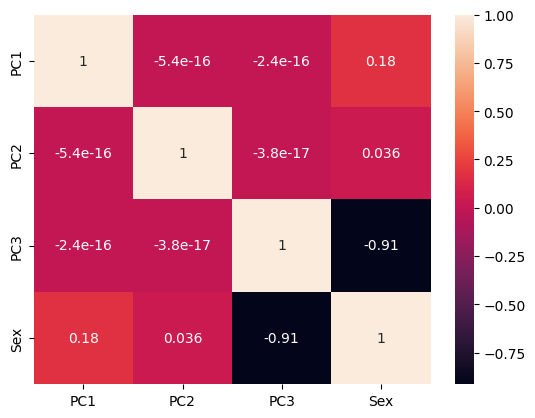

In [10]:
sns.heatmap(pca_df.drop('Population',axis=1).corr(),annot=True)

<Axes: xlabel='None', ylabel='PC3'>

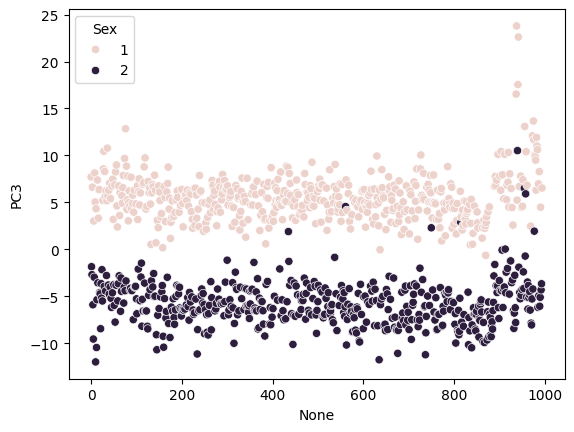

In [27]:
sns.scatterplot(x=pca_df.index,y=(pca_df['PC3']),hue=pca_df['Sex'])

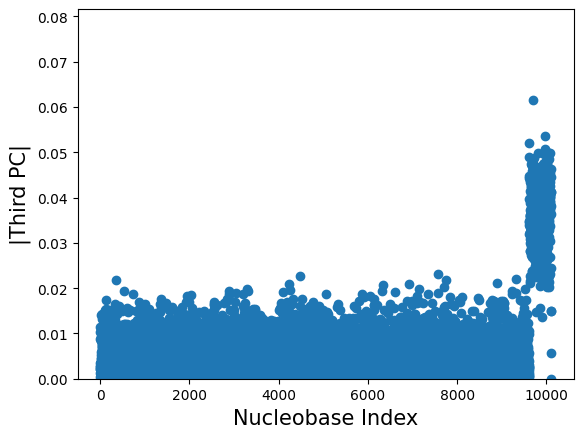

In [31]:
plt.figure()
plt.scatter(np.arange(1,pca.components_[2].shape[0]+1), np.absolute(pca.components_[2]))
plt.xlabel('Nucleobase Index', fontsize=15)
plt.ylabel('|Third PC|', fontsize=15)
plt.savefig('part_f.png', format ='png')
plt.ylim([0, max(np.absolute(pca.components_[2]))+0.02])
plt.show()

In [33]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('PC3 ~ C(Population) + C(Sex)', data=pca_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                     sum_sq     df            F        PR(>F)
C(Population)   1294.486911    6.0    43.827365  1.310189e-47
C(Sex)         31363.761812    1.0  6371.285930  0.000000e+00
Residual        4858.678962  987.0          NaN           NaN


In [21]:
population_map = {pop: idx for idx, pop in enumerate(unique_populations)}
pca_df['pop_cat'] = pca_df['Population'].map(population_map)

<Axes: >

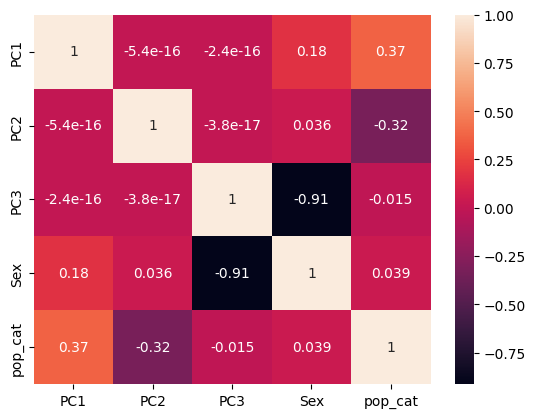

In [24]:
sns.heatmap(pca_df.drop('Population',axis=1).corr(),annot=True)

<Axes: xlabel='PC1', ylabel='PC2'>

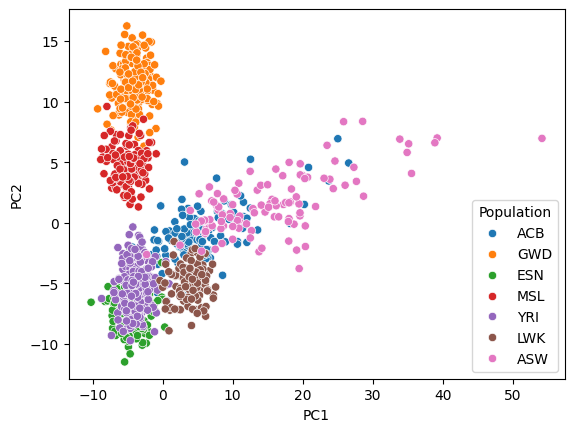

In [30]:
sns.scatterplot(x=pca_df['PC1'],y=(pca_df['PC2']),hue=pca_df['Population'])

In [37]:
pca_df.drop('Population',axis=1).corr()

,PC1,PC2,PC3,Sex,pop_cat
PC1,1.000000e+00,-5.365217e-16,-2.351712e-16,0.175596,0.370227
PC2,-5.365217e-16,1.000000e+00,-3.825060e-17,0.036261,-0.323638
PC3,-2.351712e-16,-3.825060e-17,1.000000e+00,-0.914246,-0.015377
Sex,1.755962e-01,3.626099e-02,-9.142459e-01,1.000000,0.038860
pop_cat,3.702274e-01,-3.236375e-01,-1.537741e-02,0.038860,1.000000
